In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4

from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [2]:
t_half = 3.052*60 #initial conditions
N0 = 1000
t1 = 1000
n_timepoints = 1000

def simulate_monte_carlo(N0, t1, n_timepoints):
    dt = t1 / n_timepoints #Calculating the interval between each time division
    count_tl = np.zeros((n_timepoints)) #creating zero array to put the counts into
    count_pb = np.zeros((n_timepoints))
    atoms= np.ones((N0)) #Creating an array of numbers to represent the atoms in the simulation
    p_decay = 1 - 2**(-dt / t_half) #Calculating the decay probabilities in the time interval
    for time in range(n_timepoints):
        count_tl[time]   = (atoms == 1).sum() #Counting how many atoms remain in the interval
        count_pb[time]   = (atoms == 2).sum() #Counting how many atoms are gained in the interval
        for atom in range(N0):
            if atoms[atom] == 1: #Deciding whether the given atom should decay
                if random.random() <= p_decay:
                    atoms[atom] = 2
                else:
                    atoms[atom] = 1
                
    return count_tl, count_pb

In [3]:
timebase = np.arange(0, t1, t1/n_timepoints) #creating the array of times for use in the analytic solution and scipy
n_tl, n_pb = simulate_monte_carlo(N0, t1, n_timepoints) #Calling the Monte Carlo Simulation   

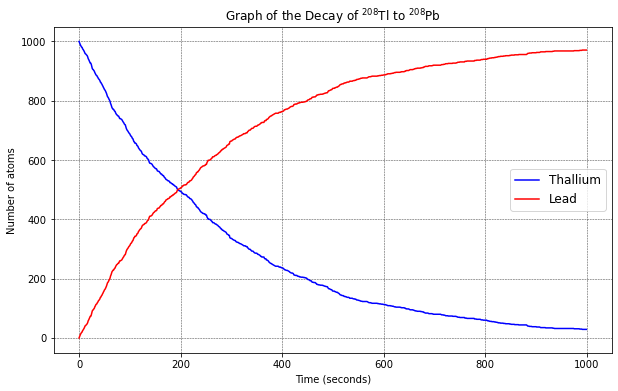

In [4]:
plt.figure(figsize=(10, 6)) #Plotting code
plt.plot(timebase, n_tl, label = 'Thallium', color = 'blue')
plt.plot(timebase, n_pb, label = 'Lead', color = 'red')
plt.title('Graph of the Decay of $^{208}$Tl to $^{208}$Pb')
plt.ylabel('Number of atoms')
plt.xlabel('Time (seconds)')
plt.legend(prop = {'size' : 12}) 
plt.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)
plt.show()

In [5]:
def dec_pdf(x, tau=3.052*60):
    return (np.log(2)/tau)*2**(-x/tau)

def dec_cdf(x, tau=3.052*60):
    """CDF of exponetial distribution."""
    return 1 - 2**(-x/tau)

def dec_icdf(p, tau=3.052*60):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -tau*np.log2(1-p)

In [6]:
u = np.random.random(1000)
v = dec_icdf(u)

Text(0.5, 0, 'Time (seconds)')

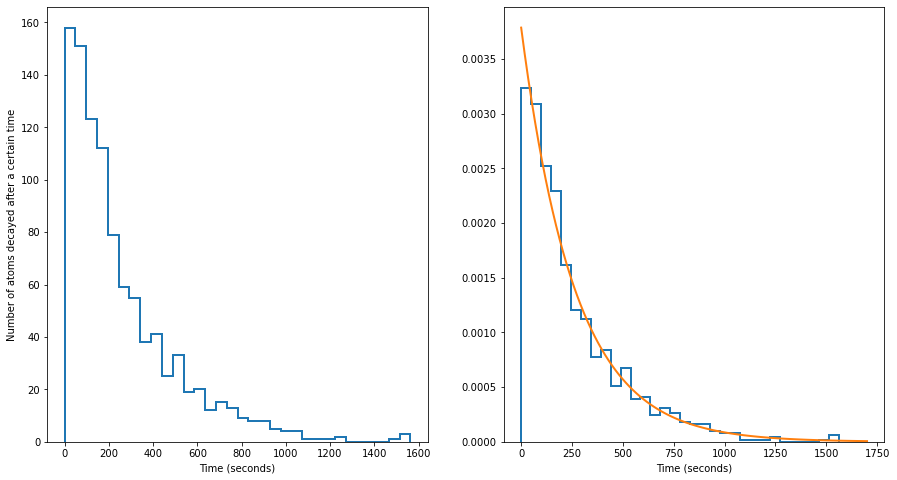

In [7]:
x = np.linspace(0,1700,100)
b = np.histogram_bin_edges(v, bins='sqrt')
figure, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15,8))
ax1.hist(v, histtype='step', bins=b, linewidth=2)
ax2.hist(v, histtype='step', bins=b, density = True, linewidth=2) # 'density = True' ensures that the area underneath the 
                                                                    # histogram is normalized to one, as to then overimpose 
                                                                    # the PDF correctly
ax2.plot(x, dec_pdf(x), linewidth=2)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Number of atoms decayed after a certain time')
ax2.set_xlabel('Time (seconds)')

After 0.0784 seconds 842.0 atoms have still not decayed


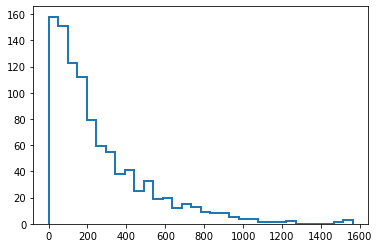

In [8]:
c = plt.hist(v, histtype='step', bins=b, linewidth=2)
cs = np.cumsum(c[0])
print('After {:.3} seconds {:.5} atoms have still not decayed'.format(c[1][0], 1000-cs[0]))
# by changing the index as c[1][i] and cs[i] one can find how many atoms have not decayed at a certain time (center of bin of
# the histogram)

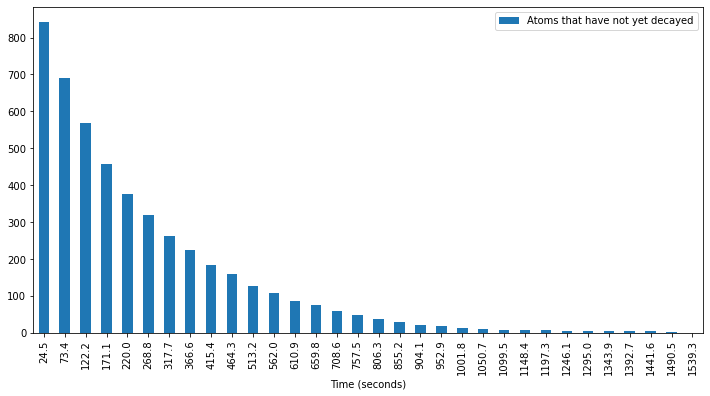

In [9]:
bin_centers = (b[:-1] + b[1:])/2.
m = 1000 - np.cumsum(c[0])
bin_centers = np.around(bin_centers, decimals = 1)

df = pd.DataFrame({'Time (seconds)':bin_centers,'Atoms that have not yet decayed':m})
df.plot(kind='bar', x='Time (seconds)', y='Atoms that have not yet decayed', figsize = (12, 6))

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [10]:
from random import random

Z = 79
e = 1.602e-19
E = 7.7e6*e
epsilon0 = 8.854e-12
a0 = 5.292e-11
sigma = a0/100
N = 1000000

refl = 0
for i in range(N):
    z = np.random.random()
    r = np.sqrt(-2*sigma*sigma*np.log(1-z))
    theta = 2*np.pi*np.random.random()
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    b = np.sqrt(x*x+y*y)
    if b<Z*e*e/(2*np.pi*epsilon0*E):
        refl += 1

print(refl,"particles were reflected out of",N)

1563 particles were reflected out of 1000000


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [11]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

N=100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N
p = count/N
sigma = 2*np.sqrt(p*(1-p)/N)
print('{:.6} +/- {:.3}'.format(I, sigma))

1.44754 +/- 0.00283


In [12]:
N=100000
count=0
Im = 0
a = 0
b = 0
sig = 0
for i in range(N):
    x=2*np.random.random()
    Im += f(x)
    a += f(x)**2
I=(2/N)*Im
b = ((1/N)*(Im))**2
sig = np.sqrt((a/N)-b)
sigma = 2*sig*np.sqrt(1/N)
print('{:.6} +/- {:.3}'.format(I, sigma))

1.4468 +/- 0.00167


4\. **Monte Carlo integration in high dimension**

* Start off by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [13]:
def nSphereVolume(dim, iterations):
    count_in_sphere = 0

    for count_loops in range(iterations):
        point = np.random.uniform(-1.0, 1.0, dim)
        distance = np.linalg.norm(point)
        if distance < 1.0:
            count_in_sphere += 1

    return np.power(2.0, dim) * (count_in_sphere / iterations)

print('The area of a circle of unit radius is {}'.format(nSphereVolume(2, 100000)))
print('The area of a 10D sphere of unit radius is {}'.format(nSphereVolume(10, 100000)))

The area of a circle of unit radius is 3.14464
The area of a 10D sphere of unit radius is 2.31424


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [14]:
def g(x): 
    return (x**(-0.5))/(np.exp(x)+1)
def w(x):
    return 1/np.sqrt(x)

In [15]:
def invsq_pdf(x):
    return 1/(2*np.sqrt(x))

def invsq_cdf(x):
    return np.sqrt(x)

def invsq_icdf(p):
    return (p**2)

In [16]:
u = np.random.random(100000)
v = invsq_icdf(u)

In [17]:
N = 100000
Im = 0
a = 0
b = 0
for i in range(N):
    x = v[i]
    Im += g(x)/w(x)
I = (2*Im)/N
print(I)

0.8390301613520681
